This project combining Segmentation, Image Editing and Generation by using Clipseg for Segmentation(MIT licence for the code, but not for the pretrained weight, Pretrained weights can only be used for research)

# Installing Libraries

In [1]:
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 66.4 MB/s eta 0:00:00


# Import Libraries

In [2]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

# Importing Clip and ClipSeg Repos

In [3]:
!pip install -q git+https://github.com/openai/CLIP.git
!git clone https://github.com/timojl/clipseg

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
Cloning into 'clipseg'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 232 (delta 72), reused 58 (delta 58), pack-reused 147 (from 1)
Receiving objects: 100% (232/232), 1.40 MiB | 22.41 MiB/s, done.
Resolving deltas: 100% (126/126), done.


## Move Into Clipseg folder

In [4]:
%cd clipseg

/content/clipseg


## Get the weights for the clipseg model

In [5]:
! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
! unzip -d weights -j weights.zip
# Dont have MIT licence so cant be used for commercial purposes

--2024-10-14 11:31:20--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [        <=>         ]   9.68M  4.56MB/s    in 2.1s    

2024-10-14 11:31:23 (4.56 MB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
 extracting: weights/rd16-uni.pth    
 extracting: weights/rd64-uni-refined.pth  
 extracting: weights/rd64-uni.pth    


## Importing Clip and ClipSeg model

In [6]:
import clip
from models.clipseg import CLIPDensePredT
# clipseg model

# load clipseg model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();
#inference mode

# non-strict mode: decoder weights only not CLIP weights
model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False);


100%|████████████████████████████████████████| 335M/335M [00:02<00:00, 140MiB/s]
<ipython-input-6-32a885a3e22a>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_

# Importing Stable Diffusion Model

In [8]:
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir = "stabilityai/stable-diffusion-2-inpainting"

# Scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder = "scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                      scheduler = scheduler,
                                                      revision = "fp16",
                                                      torch_dtype = torch.float16).to("cuda")

pipe.enable_xformers_memory_efficient_attention()


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
unet/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb

# Image

Source image size: 3648 x 5472
New source image size: (512, 512)


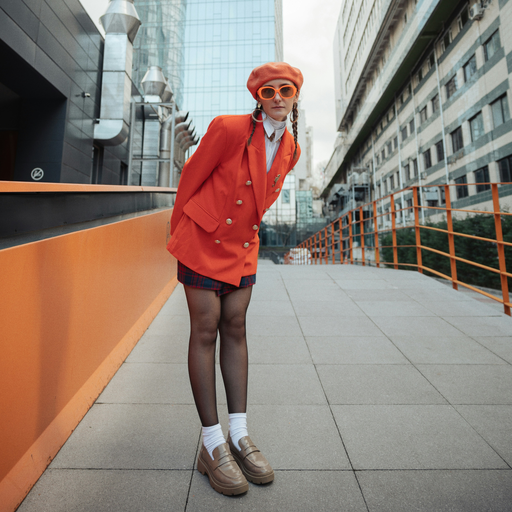

In [11]:
target_width, target_height = 512, 512
source_image = Image.open('diffusion-example-image.jpg')

width, height = source_image.size
print(f"Source image size: {width} x {height}")

source_image = source_image.crop((0, height-width, width, height))
# box = (left,upper,right,lower)
source_image = source_image.resize((target_width, target_height), Image.LANCZOS)
print(f"New source image size: {source_image.size}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tensor_image = transform(source_image).unsqueeze(0)
display(source_image)

# Creating masks for the parts

In [12]:
prompts = ['a hat', 'a coat', 'shoes', 'socks']
# guiding it with text what to find

#Using ClipSeg to identify elements in picture
with torch.no_grad():
  preds = model(tensor_image.repeat(len(prompts),1,1,1), prompts)[0]

# GPT4

With prompt i wrote this code

In [13]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


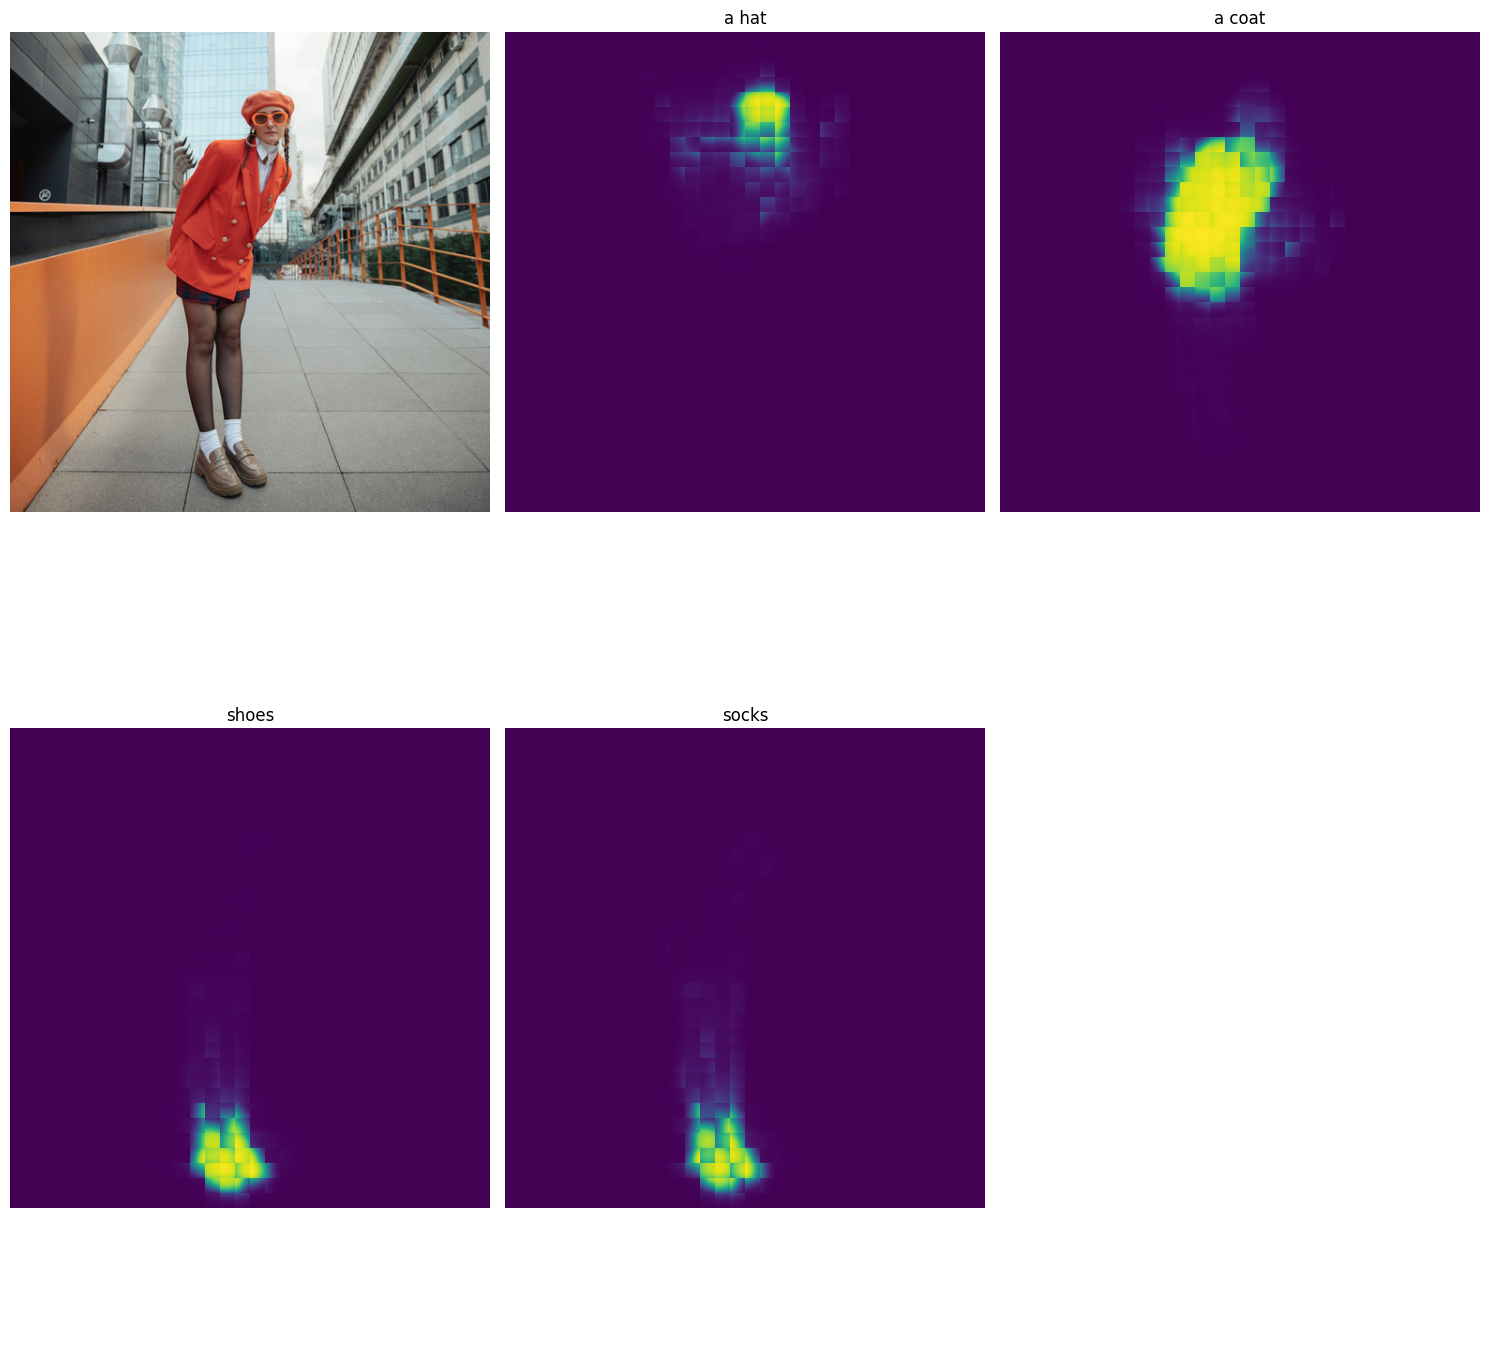

In [14]:
create_image_grid(source_image, preds, prompts, 2, 3)

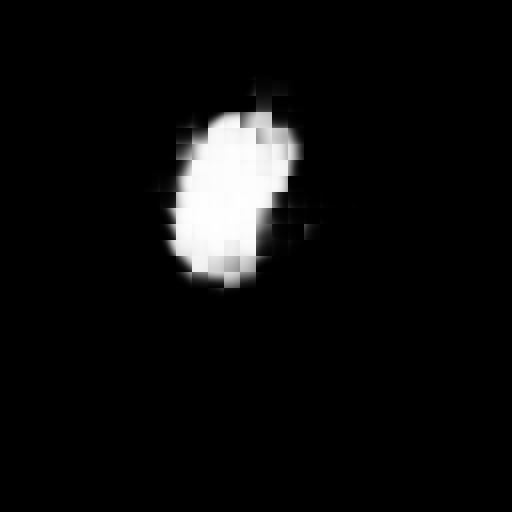

In [15]:
# Decide which mask we want to work with. In this case i pick coat
mask_number = 1

# Normalizing mask values by computing the area under Gaussian Probability density function
# Calculating the cumulative distribution with ndtr
processed_mask = torch.special.ndtr(preds[mask_number][0])

# Our model wants PIL Image
stable_diffusion_mask = transforms.ToPILImage()(processed_mask)
display(stable_diffusion_mask)

# Setting Up transformation prompts

In [20]:
num_images_per_prompt = 4
inpainting_prompts = ["skulls", "a zebra coat", "red flowers", "cyberpunk"]

generator = torch.Generator(device="cuda").manual_seed(15)

# Run stable diffusion pipeline
encoded_images = []

for i in range(num_images_per_prompt):
  image = pipe(prompt = inpainting_prompts[i],
               guidance_scale = 7.7,
               num_inference_steps = 65,
               generator = generator,
               image = source_image,
               mask_image = stable_diffusion_mask).images[0]
  encoded_images.append(image)

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

In [21]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)

Output hidden; open in https://colab.research.google.com to view.

# Displaying detected masks on top of source image

In [22]:
def create_image_plus_masks_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert the original image to a NumPy array
        original_image_np = np.array(original_image)

        # Normalize tensor images, convert them to 3-channel format, and blend them with the original image
        images = [
            cv2.add(
                original_image_np,
                cv2.applyColorMap((torch.sigmoid(img).squeeze(0).numpy() * 255).astype(np.uint8), cv2.COLORMAP_HOT)[:,:,[2,1,0]] * (torch.sigmoid(img).squeeze(0).numpy() > 0.5).astype(np.uint8)[:, :, np.newaxis]
            )
            for img in images
        ]

        # Convert the blended images back to PIL format
        images = [to_pil_image(img) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


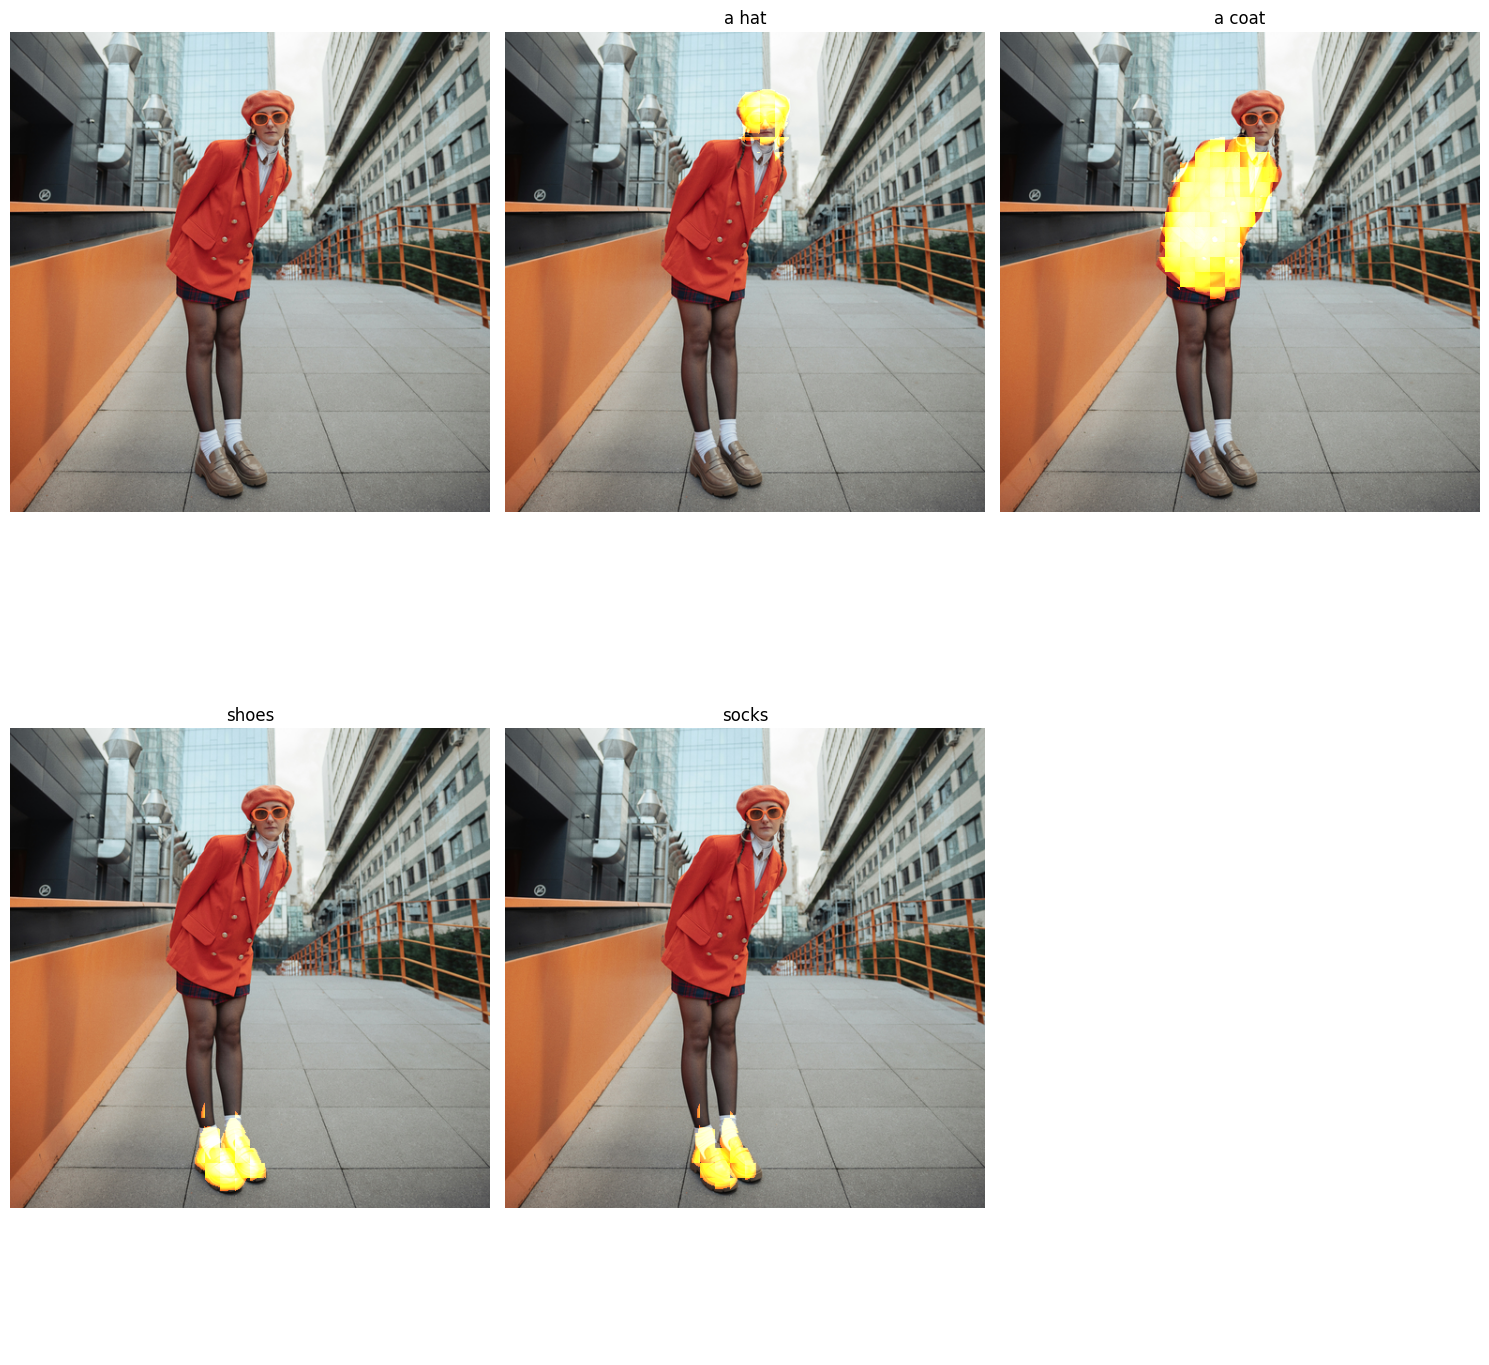

In [23]:
create_image_plus_masks_grid(source_image, preds, prompts, 2, 3)

In [24]:
def create_image_plus_masks_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert the original image to a NumPy array
        original_image_np = np.array(original_image)

        # Create a solid yellow color mask with the same size as the original image
        yellow_mask = np.zeros_like(original_image_np)
        yellow_mask[..., 0] = 255  # Red channel
        yellow_mask[..., 1] = 255  # Green channel

        # Normalize tensor images, create a binary mask, and blend them with the original image
        images = [
            np.where(
                (torch.sigmoid(img).squeeze(0).numpy() > 0.5)[:, :, np.newaxis],
                yellow_mask,
                original_image_np
            )
            for img in images
        ]

        # Convert the blended images back to PIL format
        images = [to_pil_image(img) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


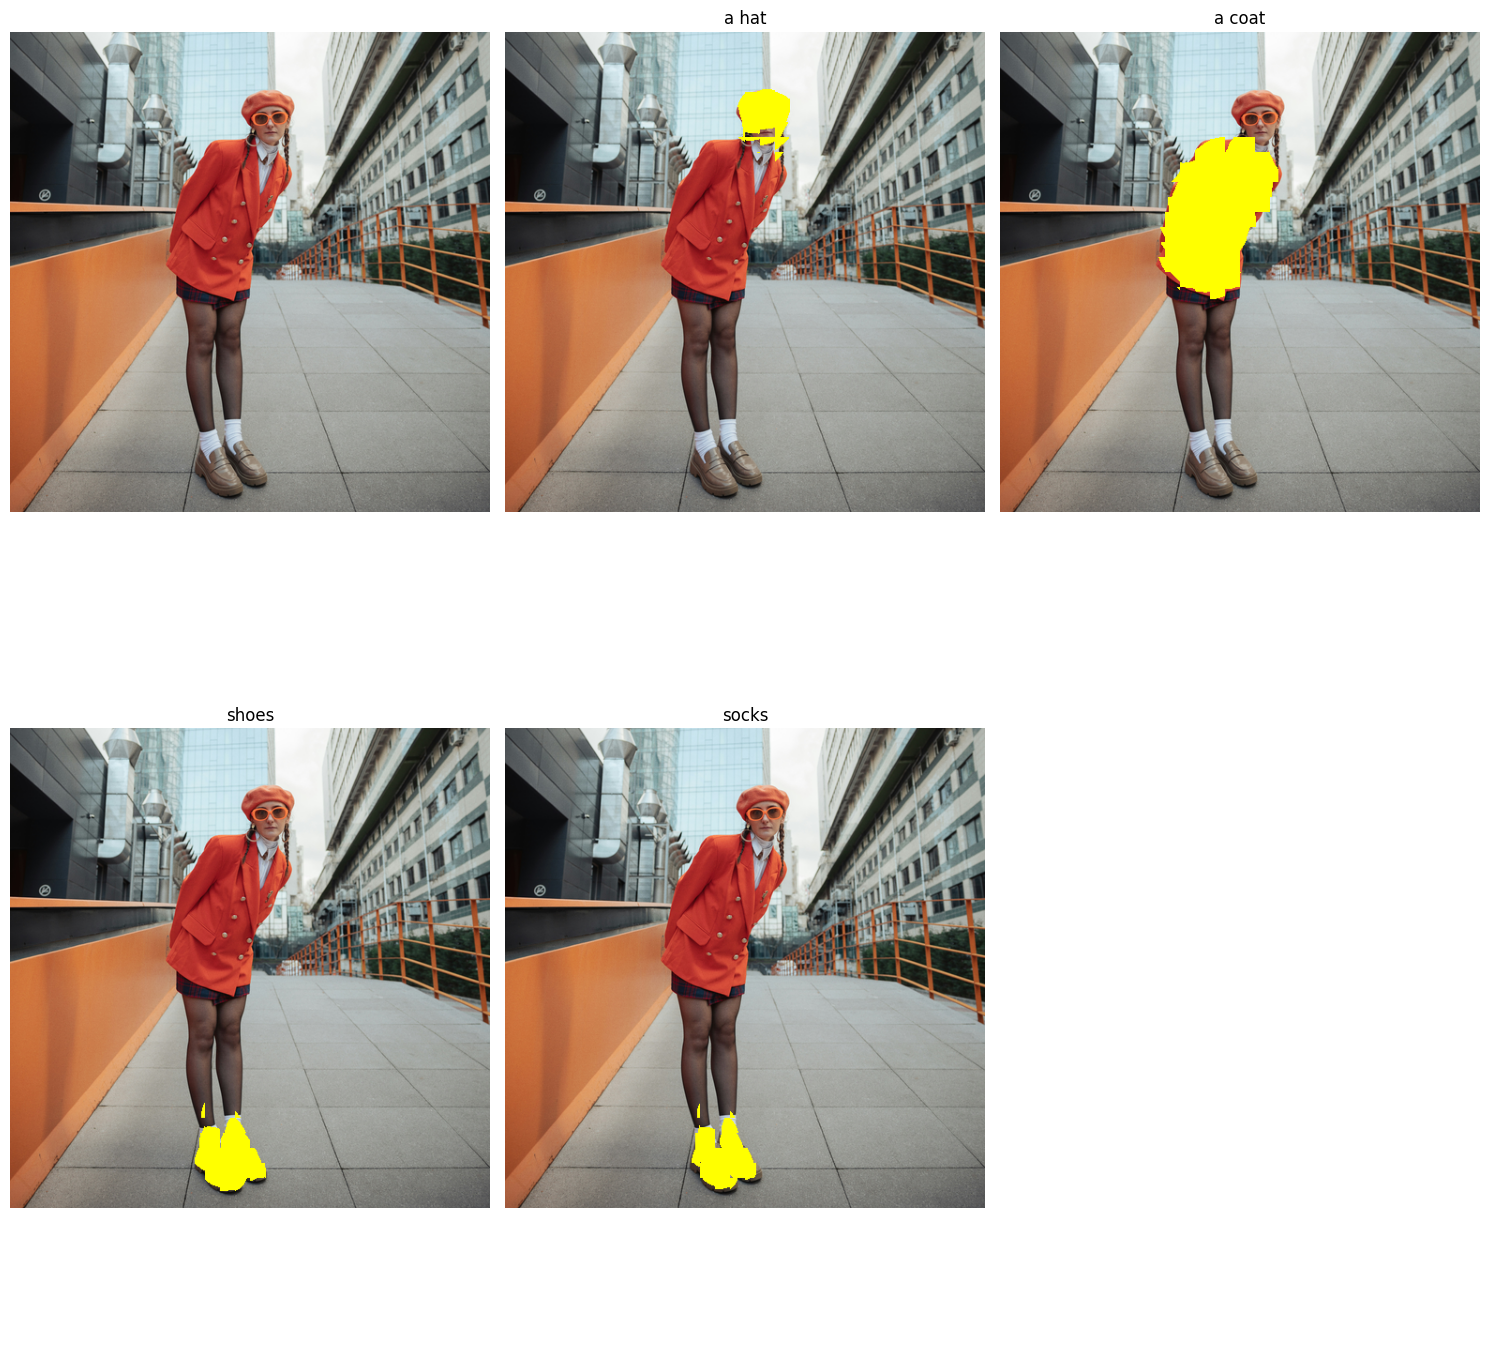

In [25]:
create_image_plus_masks_grid(source_image, preds, prompts, 2, 3)